In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.metrics import r2_score
from lmfit import Parameters, minimize, fit_report
from scipy.optimize import curve_fit
from lmfit.models import PowerLawModel

# Global plot parameters
plt.rcParams.update({'font.size':25, 'lines.markersize':10})
plt.rcParams.update({'mathtext.fontset':'cm'})
plt.rcParams.update({'font.family':'Times New Roman'})


In [2]:
def power_fit_lmfit(params, x, y):
        a = params['a']
        b = params['b']
        y_fit = a*x**b
        
        return y_fit-y

def func_powerlaw(x, a, b):
        return a*x**b

In [3]:
def calc_rsquared(x, y, amplitude, exponent):
    yhat = func_powerlaw(x, amplitude, exponent)

    return r2_score(y, yhat)

In [4]:
figure_path= Path(r'./figures')

dataBase_path = r'./'
AUV_file = r'AUV_Sw_scaling.xlsx'

data_path = Path(dataBase_path, AUV_file)
auv_data = pd.read_excel(data_path, sheet_name='AUV Data')

# break up the data frame into perspective locomotion modes
auvs = auv_data['Model'].unique()
auv_sim_dfs = [auv_data[auv_data['Model']==mode] for mode in auvs]

auvDF_1 = auv_data[auv_data['Number Thrusters']==1]
auvDF_2 = auv_data[auv_data['Number Thrusters']==2]

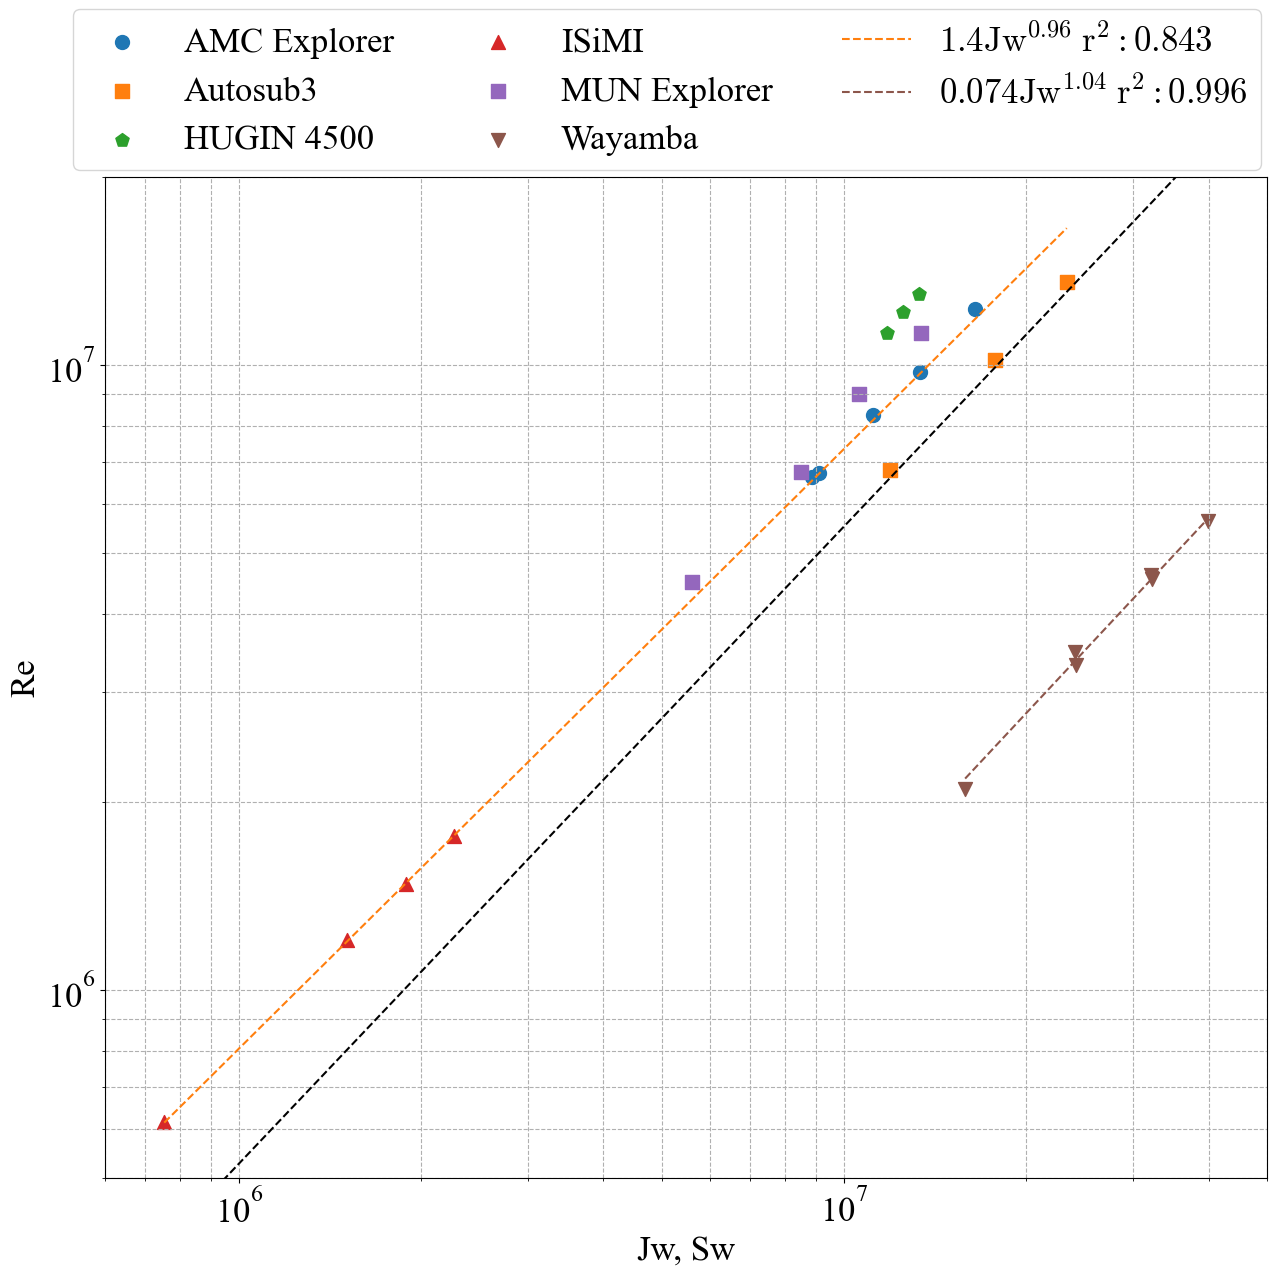

In [5]:
# plot Reynolds number and SW
fig1, ax1 = plt.subplots(figsize=(15,13), facecolor='w')

markers = ['o', 's', 'p', '^', 's', 'v']

model = PowerLawModel(prefix='p_')

Jw_1 = auvDF_1['Jw'].values
Jw_2 = auvDF_2['Jw'].values

Jw_1_index = np.argsort(Jw_1)
Jw_2_index = np.argsort(Jw_2)

Jw_1 = Jw_1[Jw_1_index]
Jw_2 = Jw_2[Jw_2_index]

Re_1 = auvDF_1['Re'].values[Jw_1_index]
Re_2 = auvDF_2['Re'].values[Jw_2_index]

pars_1 = model.guess(Re_1, x=Jw_1)
pars_1['p_amplitude'].set(value=1.2, min=0.001, max=10.0)
pars_1['p_exponent'].set(value=0.96, min=0.9, max=1.0)

pars_2 = model.guess(Re_2, x=Jw_2)
pars_2['p_amplitude'].set(value=0.02, min=0.001, max=500.0)
pars_2['p_exponent'].set(value=1.04, min=0.001, max=1.5)

Jw_fit_1 = model.fit(Re_1, pars_1, x=Jw_1)
Jw_fit_2 = model.fit(Re_2, pars_2, x=Jw_2)

amplitude = 1.40
exponent = 0.96
r_squared = np.array([calc_rsquared(Jw_1, Re_1, amplitude, exponent), 
                      calc_rsquared(Jw_2, Re_2, Jw_fit_2.params['p_amplitude'], Jw_fit_2.params['p_exponent'])])

for i, mode in enumerate(auvs):
        ax1.scatter(auv_sim_dfs[i]['Jw'], auv_sim_dfs[i]['Re'], marker=markers[i], label=mode)
        
# ax4.plot(Jw_1, Jw_fit_1.params['p_amplitude'].value*Jw_1**Jw_fit_1.params['p_exponent'].value, 'C1' + '--', label='$\mathrm{' + str(np.round(Jw_fit_1.params['p_amplitude'].value, 1)) + 
#         'Jw^{' + str(np.round(Jw_fit_1.params['p_exponent'].value, 2)) + '}\;R^2: ' + str(np.round(1 - Jw_fit_1.redchi / np.var(Re_1, ddof=2), 3)) + '}$')
ax1.plot(Jw_1, amplitude*Jw_1**exponent, 'C1' + '--', label='$\mathrm{' + str(np.round(amplitude, 3)) + 
        'Jw^{' + str(np.round(exponent, 2)) + '}\;r^2: ' + str(np.round(r_squared[0], 3)) + '}$')
ax1.plot(Jw_2, Jw_fit_2.params['p_amplitude'].value*Jw_2**Jw_fit_2.params['p_exponent'].value, 'C5' + '--', label='$\mathrm{' + str(np.round(Jw_fit_2.params['p_amplitude'].value, 3)) + 
        'Jw^{' + str(np.round(Jw_fit_2.params['p_exponent'].value, 2)) + '}\;r^2: ' + str(np.round(1 - Jw_fit_2.redchi / np.var(Re_2, ddof=2), 3)) + '}$')

dx = np.linspace(1, 1e9)
Re_low = 0.03*dx**1.31
Re_high = 0.4*dx**1.02

#ax5.plot(dx, Re_low, 'k-')
ax1.plot(dx, Re_high, 'k--')
ax1.plot([8e3, 8e3], [1, 1e9], 'b--')

ax1.set_xlabel('Jw, Sw')
ax1.set_ylabel('Re')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([5e5, 2e7])
ax1.set_xlim([6e5, 5e7])
ax1.grid(which='both', linestyle='--')
ax1.legend(ncol=3, loc=4, bbox_to_anchor=(1.01, 0.99))
fig1.savefig(figure_path.joinpath('AUV_jw_sw_noBlades.pdf'), facecolor='w', dpi=300, bbox_inches='tight')

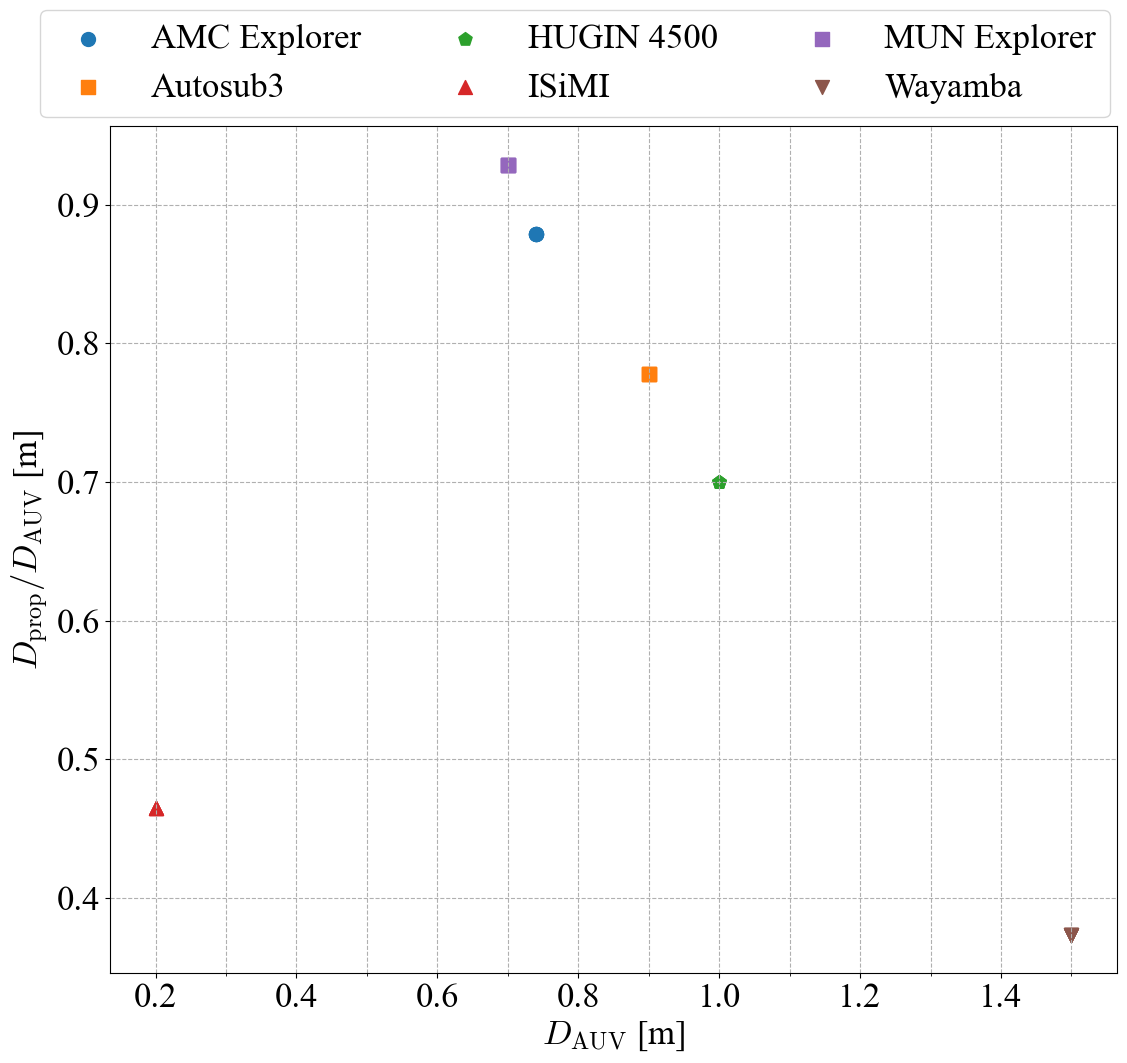

In [6]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
# plot Reynolds number and SW
fig2, ax2 = plt.subplots(figsize=(13,11), facecolor='w')

markers = ['o', 's', 'p', '^', 's', 'v']

model = PowerLawModel(prefix='p_')

for i, mode in enumerate(auvs):
    ax2.scatter(auv_sim_dfs[i]['Diameter'], np.divide(auv_sim_dfs[i]['Prop Diameter [m]'],auv_sim_dfs[i]['Diameter']), marker=markers[i], label=mode)
ax2.set_xlabel('$D_{\mathrm{AUV}}$ [m]')
ax2.set_ylabel('$D_{\mathrm{prop}}/D_{\mathrm{AUV}}$ [m]')
# ax5.set_yscale('log')
# ax5.set_xscale('log')

ax2.xaxis.set_minor_locator(AutoMinorLocator(2))
ax2.grid(which='both', linestyle='--')
ax2.legend(ncol=3, loc=4, bbox_to_anchor=(1.01, 0.99))
fig2.savefig(figure_path.joinpath('AUV_prop_diameter.pdf'), facecolor='w', dpi=300, bbox_inches='tight')

In [7]:
blades = auv_data['Number Blades'].unique()
blades.sort()
blades_dfs = [auv_data[auv_data['Number Blades']==blade] for blade in blades]

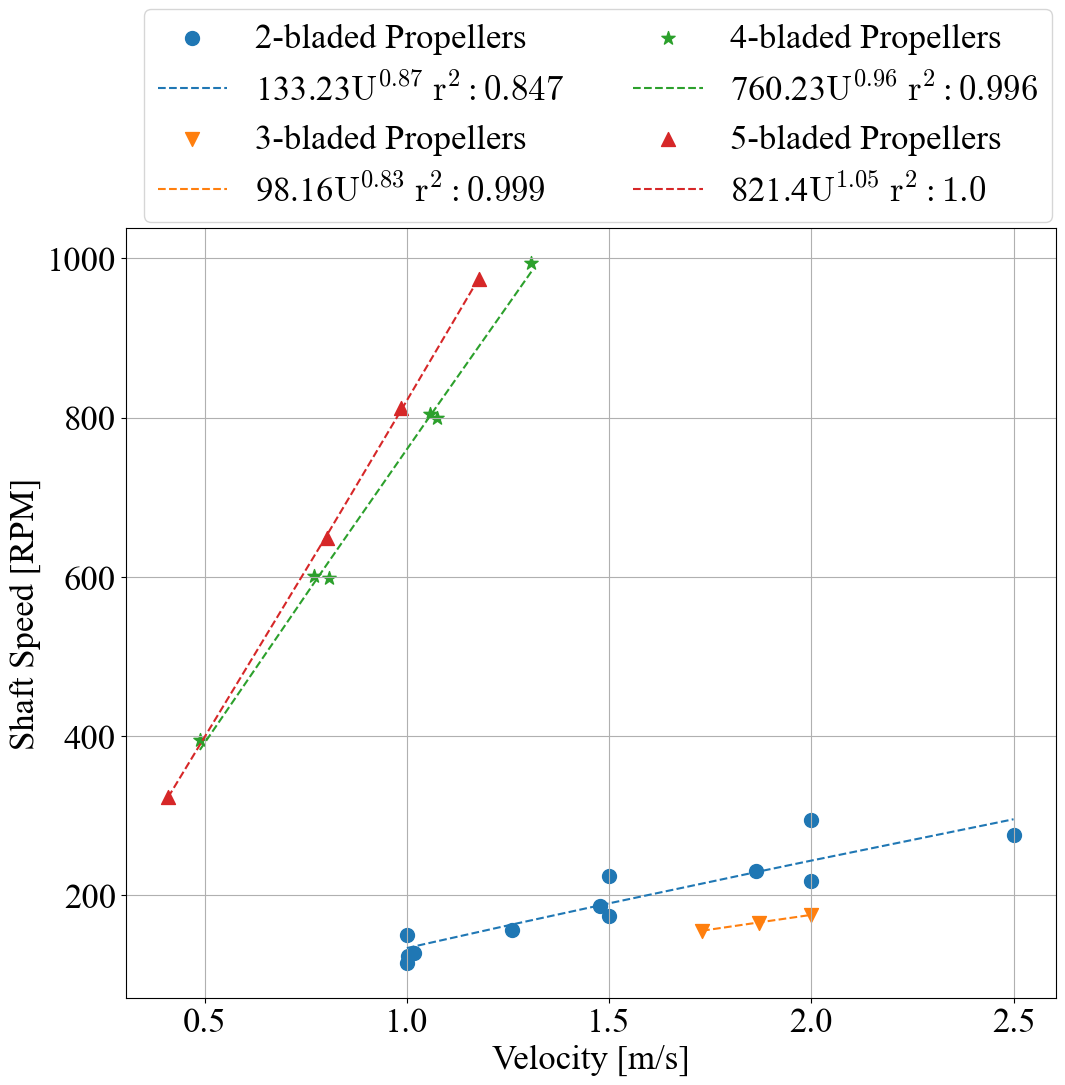

In [8]:
fig3, ax3 = plt.subplots(figsize=(12,10), facecolor='w')
marker_size=50
fit_method = 'least_squares'

markers = ['o', 'v', '*', '^', 'd']
colors = ['C0', 'C1', 'C2', 'C3']


for i, numblades in enumerate(blades):
        # perform fits for data
        data = blades_dfs[i].sort_values(by=['Velocity [m/s]'])
        
        model = PowerLawModel(prefix='p_')

        pars = model.guess(data['Shaft RPM [rpm]'].values, x=data['Velocity [m/s]'].values)
        pars['p_amplitude'].set(value=6, min=0.001, max=1000)
        pars['p_exponent'].set(value=0.5, min=0.001, max=1.1)

        fit = model.fit(data['Shaft RPM [rpm]'], pars, x=data['Velocity [m/s]'])

        r_squared = calc_rsquared(data['Velocity [m/s]'].values, data['Shaft RPM [rpm]'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)

        ax3.scatter(data['Velocity [m/s]'], data['Shaft RPM [rpm]'], color=colors[i], marker=markers[i], label=str(numblades) + '-bladed Propellers')
        ax3.plot(data['Velocity [m/s]'], fit.params['p_amplitude'].value*data['Velocity [m/s]'].values**fit.params['p_exponent'].value, colors[i] + '--', 
                label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{U^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;r^2: ' 
                + str(np.round(r_squared, 3)) + '}$')

        # model = LinearModel(prefix='l_')
        # pars = model.guess(data['Shaft RPM [rpm]'].values, x=data['Velocity [m/s]'].values)
        # pars['l_slope'].set(value=6, min=0.001, max=1000)
        # pars['l_intercept'].set(value=0.5, min=0.001, max=1000)

        # fit = model.fit(data['Shaft RPM [rpm]'], pars, x=data['Velocity [m/s]'])
        # r_squared = calc_rsquared_linear(data['Velocity [m/s]'].values, data['Shaft RPM [rpm]'].values, fit.params['l_slope'].value, fit.params['l_intercept'].value)

        # ax2.plot(data['Velocity [m/s]'], fit.params['l_slope'].value*data['Velocity [m/s]'].values + fit.params['l_intercept'].value, colors[i] + '--', 
        #         label=str(np.round(fit.params['l_slope'].value, 2)) + '$\mathrm{U + ' + str(np.round(fit.params['l_intercept'].value,2)) + '\;R^2: ' 
        #         + str(np.round(r_squared, 3)) + '}$')

ax3.set_xlabel('Velocity [m/s]')
ax3.set_ylabel('Shaft Speed [RPM]')
ax3.legend(ncol=2, loc=4, bbox_to_anchor=(1.015, 0.985))

# ax2.set_xlim([1e-4, 2e4])
# ax2.set_ylim([1e-3, 1e4])
# ax2.set_yscale('log')
# ax2.set_xscale('log')
ax3.grid()
fig3.savefig(figure_path.joinpath('rpm_speed.pdf'), facecolor='w', dpi=300, bbox_inches='tight')

In [9]:
auv_data = pd.read_excel(data_path, sheet_name='Torpedo Estimates')

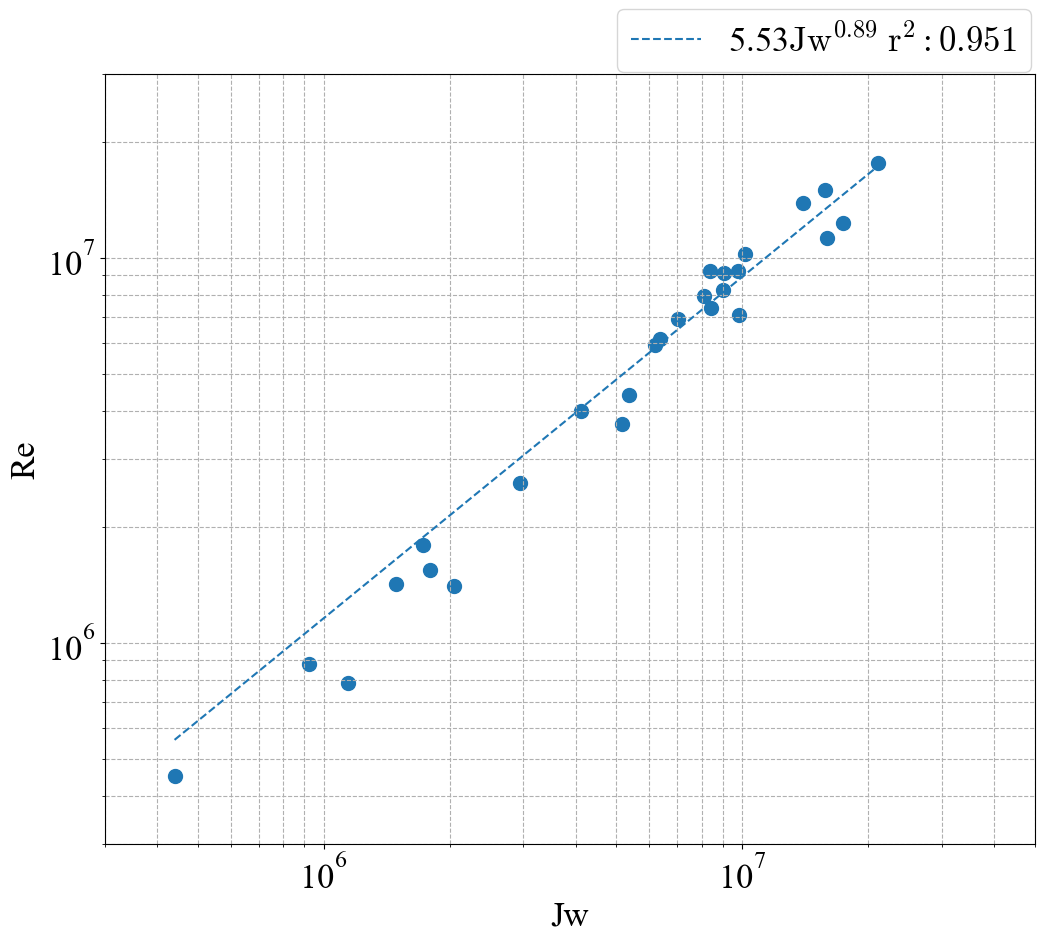

In [10]:
fig3, ax3 = plt.subplots(figsize=(12,10), facecolor='w')

data = auv_data.sort_values(by=['Jw'])
model = PowerLawModel(prefix='p_')

pars = model.guess(data['Re'].values, x=data['Jw'].values)
pars['p_amplitude'].set(value=1.4, min=0.001, max=10.0)
pars['p_exponent'].set(value=0.5, min=0.001, max=1.1)

fit = model.fit(data['Re'], pars, x=data['Jw'])

r_squared = calc_rsquared(data['Jw'].values, data['Re'].values, fit.params['p_amplitude'].value, fit.params['p_exponent'].value)

ax3.scatter(data['Jw'], data['Re'])
ax3.plot(data['Jw'], fit.params['p_amplitude'].value*data['Jw'].values**fit.params['p_exponent'].value, '--', 
                label=str(np.round(fit.params['p_amplitude'].value, 2)) + '$\mathrm{Jw^{' + str(np.round(fit.params['p_exponent'].value,2)) + '}\;r^2: ' 
                + str(np.round(r_squared, 3)) + '}$')

r_squared = calc_rsquared(data['Jw'].values, data['Re'].values, 1.4, 0.96)

# ax3.plot(data['Jw'], 1.4*data['Jw'].values**0.96, 'C1' + '--', 
#                 label=str(1.4) + '$\mathrm{Jw^{' + str(0.96) + '}\;R^2: ' 
#                 + str(np.round(r_squared, 3)) + '}$')

dx = np.linspace(1, 1e9)
Re_low = 0.03*dx**1.31
Re_high = 0.4*dx**1.02

#ax5.plot(dx, Re_low, 'k-')
# ax3.plot(dx, Re_high, 'k--')

ax3.set_xlabel('Jw')
ax3.set_ylabel('Re')
ax3.legend(ncol=2, loc=4, bbox_to_anchor=(1.015, 0.98))

ax3.set_ylim([3e5, 3e7])
ax3.set_xlim([3e5, 5e7])
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.grid(which='both', linestyle='--')
fig3.savefig(figure_path.joinpath('Jw_Re_expanded.pdf'), facecolor='w', dpi=300, bbox_inches='tight')